In [1]:
from pathlib import Path
import pandas as pd

In [2]:
from ethicml.algorithms.inprocess import GPyT, GPyTDemPar, GPyTEqOdds, LR, SVM, Agarwal, Kamiran, Kamishima, LRCV, ZafarEqOpp, ZafarAccuracy, ZafarFairness
from ethicml.evaluators import evaluate_models, CrossValidator, run_metrics, evaluate_models_parallel
from ethicml.data import Compas, Adult, load_data
from ethicml.metrics import Accuracy, ProbPos, TPR, TNR, AbsCV, ProbPos
from ethicml.preprocessing import train_test_split
from ethicml.visualisation.plot import plot_mean_std_box, single_plot_mean_std_box

In [ ]:
eo_results = evaluate_models_parallel(
    datasets=data = [Compas("Race"), Compas("Sex")],
    inprocess_models=[
        LR(),
        LRCV(),
        SVM(),
        Agarwal(fairness="EqOd"),
        Kamiran(),
#     Kamishima(),
        ZafarEqOpp(),
    ],
    metrics=[Accuracy(), TPR(), TNR()],
    per_sens_metrics=[TPR(), TNR()], 
    repeats=10,
    proportional_splits=True,
    topic="only_baselines",
)

In [9]:
eo_results

Accuracy  \
dataset     transform    model                      repeat              
Compas Race no_transform Logistic Regression, C=1.0 0-0      0.678021   
                         LRCV                       0-0      0.668289   
                         SVM                        0-0      0.688564   
                         Agarwal LR                 0-0      0.671533   
                         Kamiran & Calders LR       0-0      0.676399   
...                                                               ...   
Compas Sex  no_transform LRCV                       9-21690  0.666937   
                         SVM                        9-21690  0.693679   
                         Agarwal LR                 9-21690  0.676661   
                         Kamiran & Calders LR       9-21690  0.673420   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690  0.662075   

                                                                  TNR  \
dataset     transform    model                      repeat              
Compas Race no_transform Logistic Regression, C=1.0 0-0      0.778274   
                         LRCV                       0-0      0.757440   
                         SVM                        0-0      0.797619   
                         Agarwal LR                 0-0      0.769345   
                         Kamiran & Calders LR       0-0      0.778274   
...                                                               ...   
Compas Sex  no_transform LRCV                       9-21690  0.739583   
                         SVM                        9-21690  0.803571   
                         Agarwal LR                 9-21690  0.755952   
                         Kamiran & Calders LR       9-21690  0.751488   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690  0.721726   

                                                             TNR_race_0  \
dataset     transform    model                      repeat                
Compas Race no_transform Logistic Regression, C=1.0 0-0        0.747596   
                         LRCV                       0-0        0.730769   
                         SVM                        0-0        0.752404   
                         Agarwal LR                 0-0        0.733173   
                         Kamiran & Calders LR       0-0        0.745192   
...                                                                 ...   
Compas Sex  no_transform LRCV                       9-21690         NaN   
                         SVM                        9-21690         NaN   
                         Agarwal LR                 9-21690         NaN   
                         Kamiran & Calders LR       9-21690         NaN   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690         NaN   

                                                             TNR_race_0-race_1  \
dataset     transform    model                      repeat                       
Compas Race no_transform Logistic Regression, C=1.0 0-0               0.080529   
                         LRCV                       0-0               0.070012   
                         SVM                        0-0               0.118690   
                         Agarwal LR                 0-0               0.094952   
                         Kamiran & Calders LR       0-0               0.086839   
...                                                                        ...   
Compas Sex  no_transform LRCV                       9-21690                NaN   
                         SVM                        9-21690                NaN   
                         Agarwal LR                 9-21690                NaN   
                         Kamiran & Calders LR       9-21690                NaN   
                         ZafarEqOpp, τ=5.0, μ=1.2   9-21690                NaN   

                                                             TNR_race_0/race_1  \
dataset     transform    model      

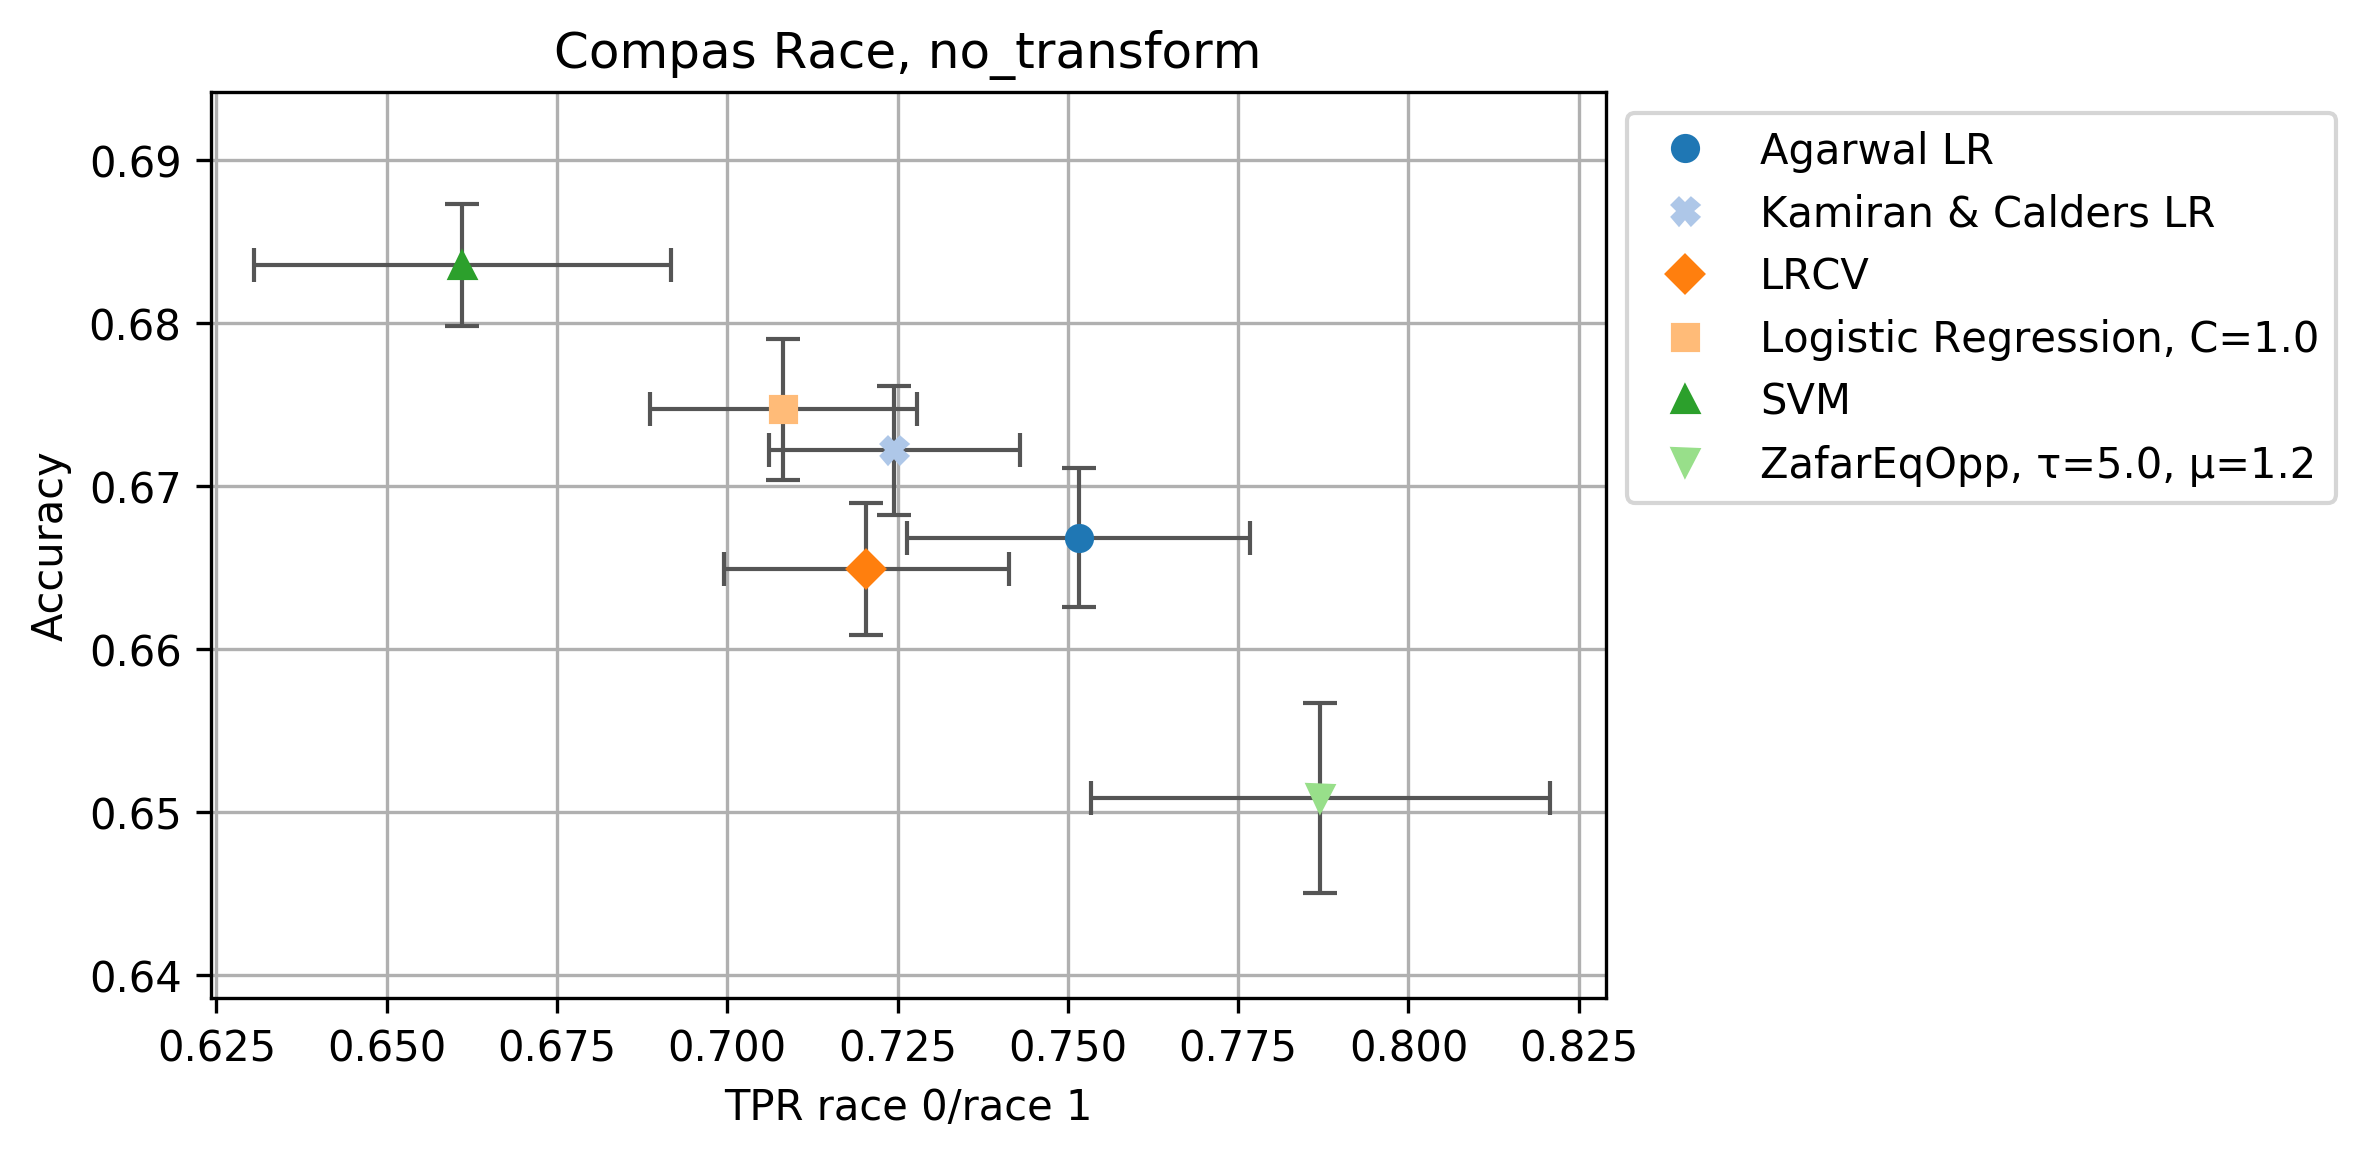

In [10]:
# results = pd.read_csv("results/Compas Race_no_transform.csv").set_index(["dataset", "transform", "model", "repeat"])

plot_mean_std_box(results, "Accuracy", "TPR_race_0/race_1", save=False, use_cross=True)[0][0]

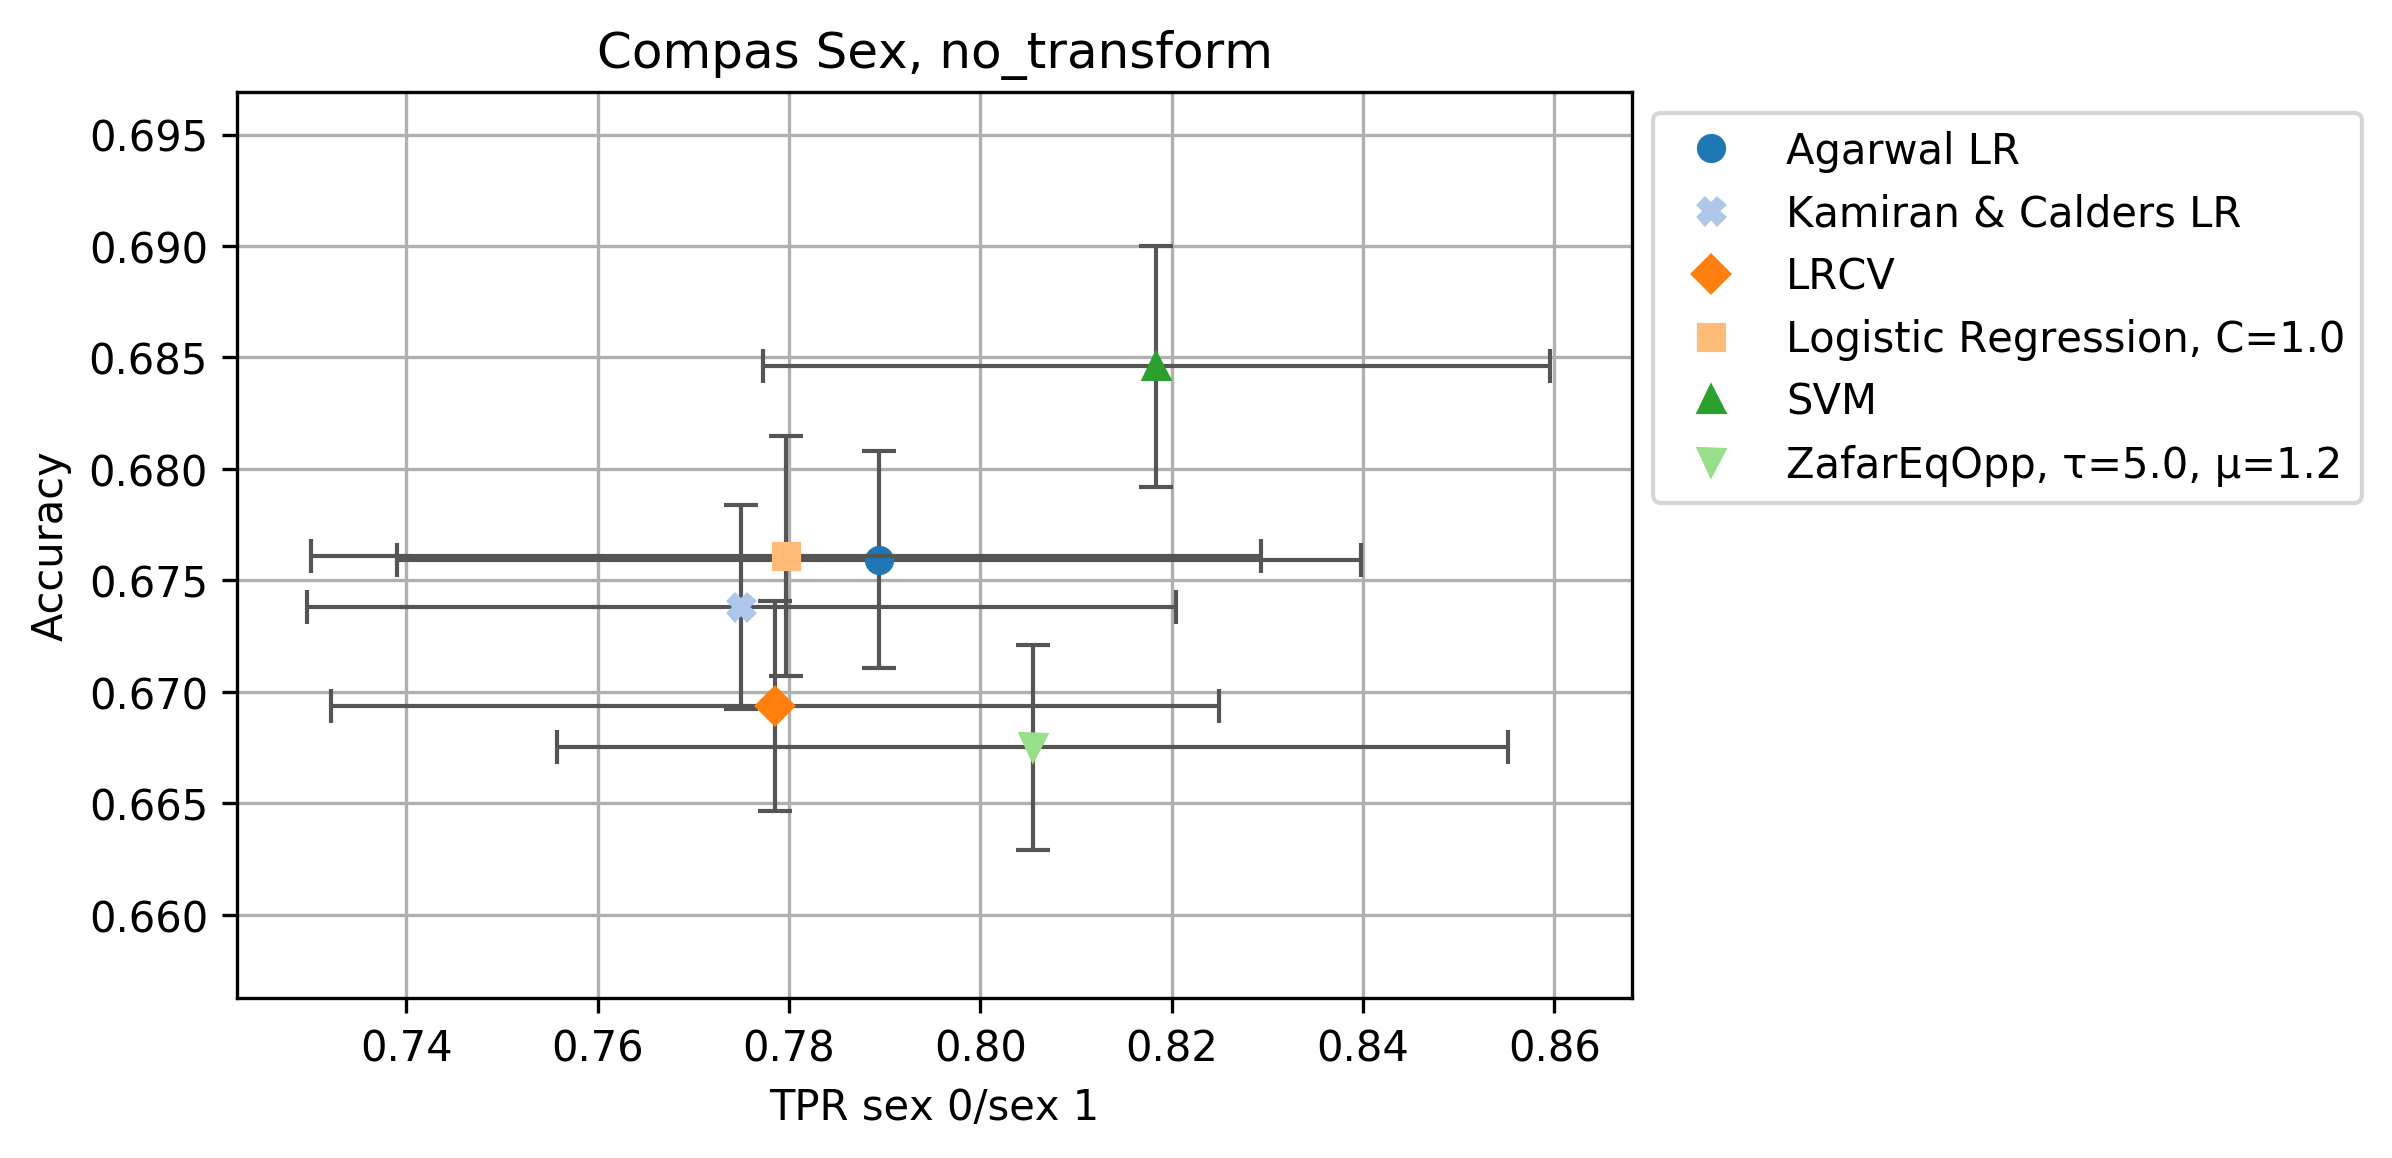

In [11]:
plot_mean_std_box(results, "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]

In [ ]:
adult_race = Adult("Race")
adult_race.sens_attrs = ['race_White']  # make s binary

dp_results = evaluate_models_parallel(
    datasets=[adult_race, Adult("Sex")],
    inprocess_models=[
        Agarwal(fairness="DP"),
        Kamiran(),
#         Kamishima(),
#         ZafarAccuracy(),
#         ZafarFairness(),
        LR(),
        LRCV(),
        SVM(),
    ],
    metrics=[Accuracy(), ProbPos(), AbsCV()],
    per_sens_metrics=[ProbPos()], 
    repeats=10,
    proportional_splits=True,
    topic="only_baselines",
    max_parallel=3,
)

  1%|          | 1/100 [01:10<1:56:24, 70.55s/it, model=Agarwal LR, dataset=Adult Race - Train (3), worker_id=1]

In [5]:
dp_results

Accuracy  \
dataset    transform    model                      repeat              
Adult Race no_transform ZafarAccuracy, γ=0.5       0-0      0.770013   
                        ZafarFairness, c=0.001     0-0      0.846086   
                        ZafarAccuracy, γ=0.5       1-2410   0.776979   
                        ZafarFairness, c=0.001     1-2410   0.852941   
                        ZafarAccuracy, γ=0.5       2-4820   0.779854   
...                                                              ...   
Adult Sex  no_transform Agarwal LR                 9-21690  0.845329   
                        Kamiran & Calders LR       9-21690  0.842565   
                        Logistic Regression, C=1.0 9-21690  0.847540   
                        LRCV                       9-21690  0.805638   
                        SVM                        9-21690  0.860254   

                                                            CV absolute  \
dataset    transform    model                      repeat                 
Adult Race no_transform ZafarAccuracy, γ=0.5       0-0         0.997609   
                        ZafarFairness, c=0.001     0-0         0.895841   
                        ZafarAccuracy, γ=0.5       1-2410      0.988399   
                        ZafarFairness, c=0.001     1-2410      0.912463   
                        ZafarAccuracy, γ=0.5       2-4820      0.919571   
...                                                                 ...   
Adult Sex  no_transform Agarwal LR                 9-21690     0.852191   
                        Kamiran & Calders LR       9-21690     0.907420   
                        Logistic Regression, C=1.0 9-21690     0.815124   
                        LRCV                       9-21690     0.932363   
                        SVM                        9-21690     0.824178   

                                                            prob_pos  \
dataset    transform    model                      repeat              
Adult Race no_transform ZafarAccuracy, γ=0.5       0-0      0.138766   
                        ZafarFairness, c=0.001     0-0      0.205108   
                        ZafarAccuracy, γ=0.5       1-2410   0.141309   
                        ZafarFairness, c=0.001     1-2410   0.202676   
                        ZafarAccuracy, γ=0.5       2-4820   0.210084   
...                                                              ...   
Adult Sex  no_transform Agarwal LR                 9-21690  0.189608   
                        Kamiran & Calders LR       9-21690  0.188391   
                        Logistic Regression, C=1.0 9-21690  0.200000   
                        LRCV                       9-21690  0.089552   
                        SVM                        9-21690  0.181979   

                                                            prob_pos_race_White_0  \
dataset    transform    model                      repeat                           
Adult Race no_transform ZafarAccuracy, γ=0.5       0-0                   0.140823   
                        ZafarFairness, c=0.001     0-0                   0.115506   
                        ZafarAccuracy, γ=0.5       1-2410                0.131329   
                        ZafarFairness, c=0.001     1-2410                0.127373   
                        ZafarAccuracy, γ=0.5       2-4820                0.279272   
...                                                                           ...   
Adult Sex  no_transform Agarwal LR                 9-21690                    NaN   
                        Kamiran & Calders LR       9-21690                    NaN   
                        Logistic Regression, C=1.0 9-21690                    NaN   
                        LRCV                       9-21690                    NaN   
                        SVM                        9-21690                    NaN   

                                                            prob_pos_race_White_0-race_White_1  \
datase

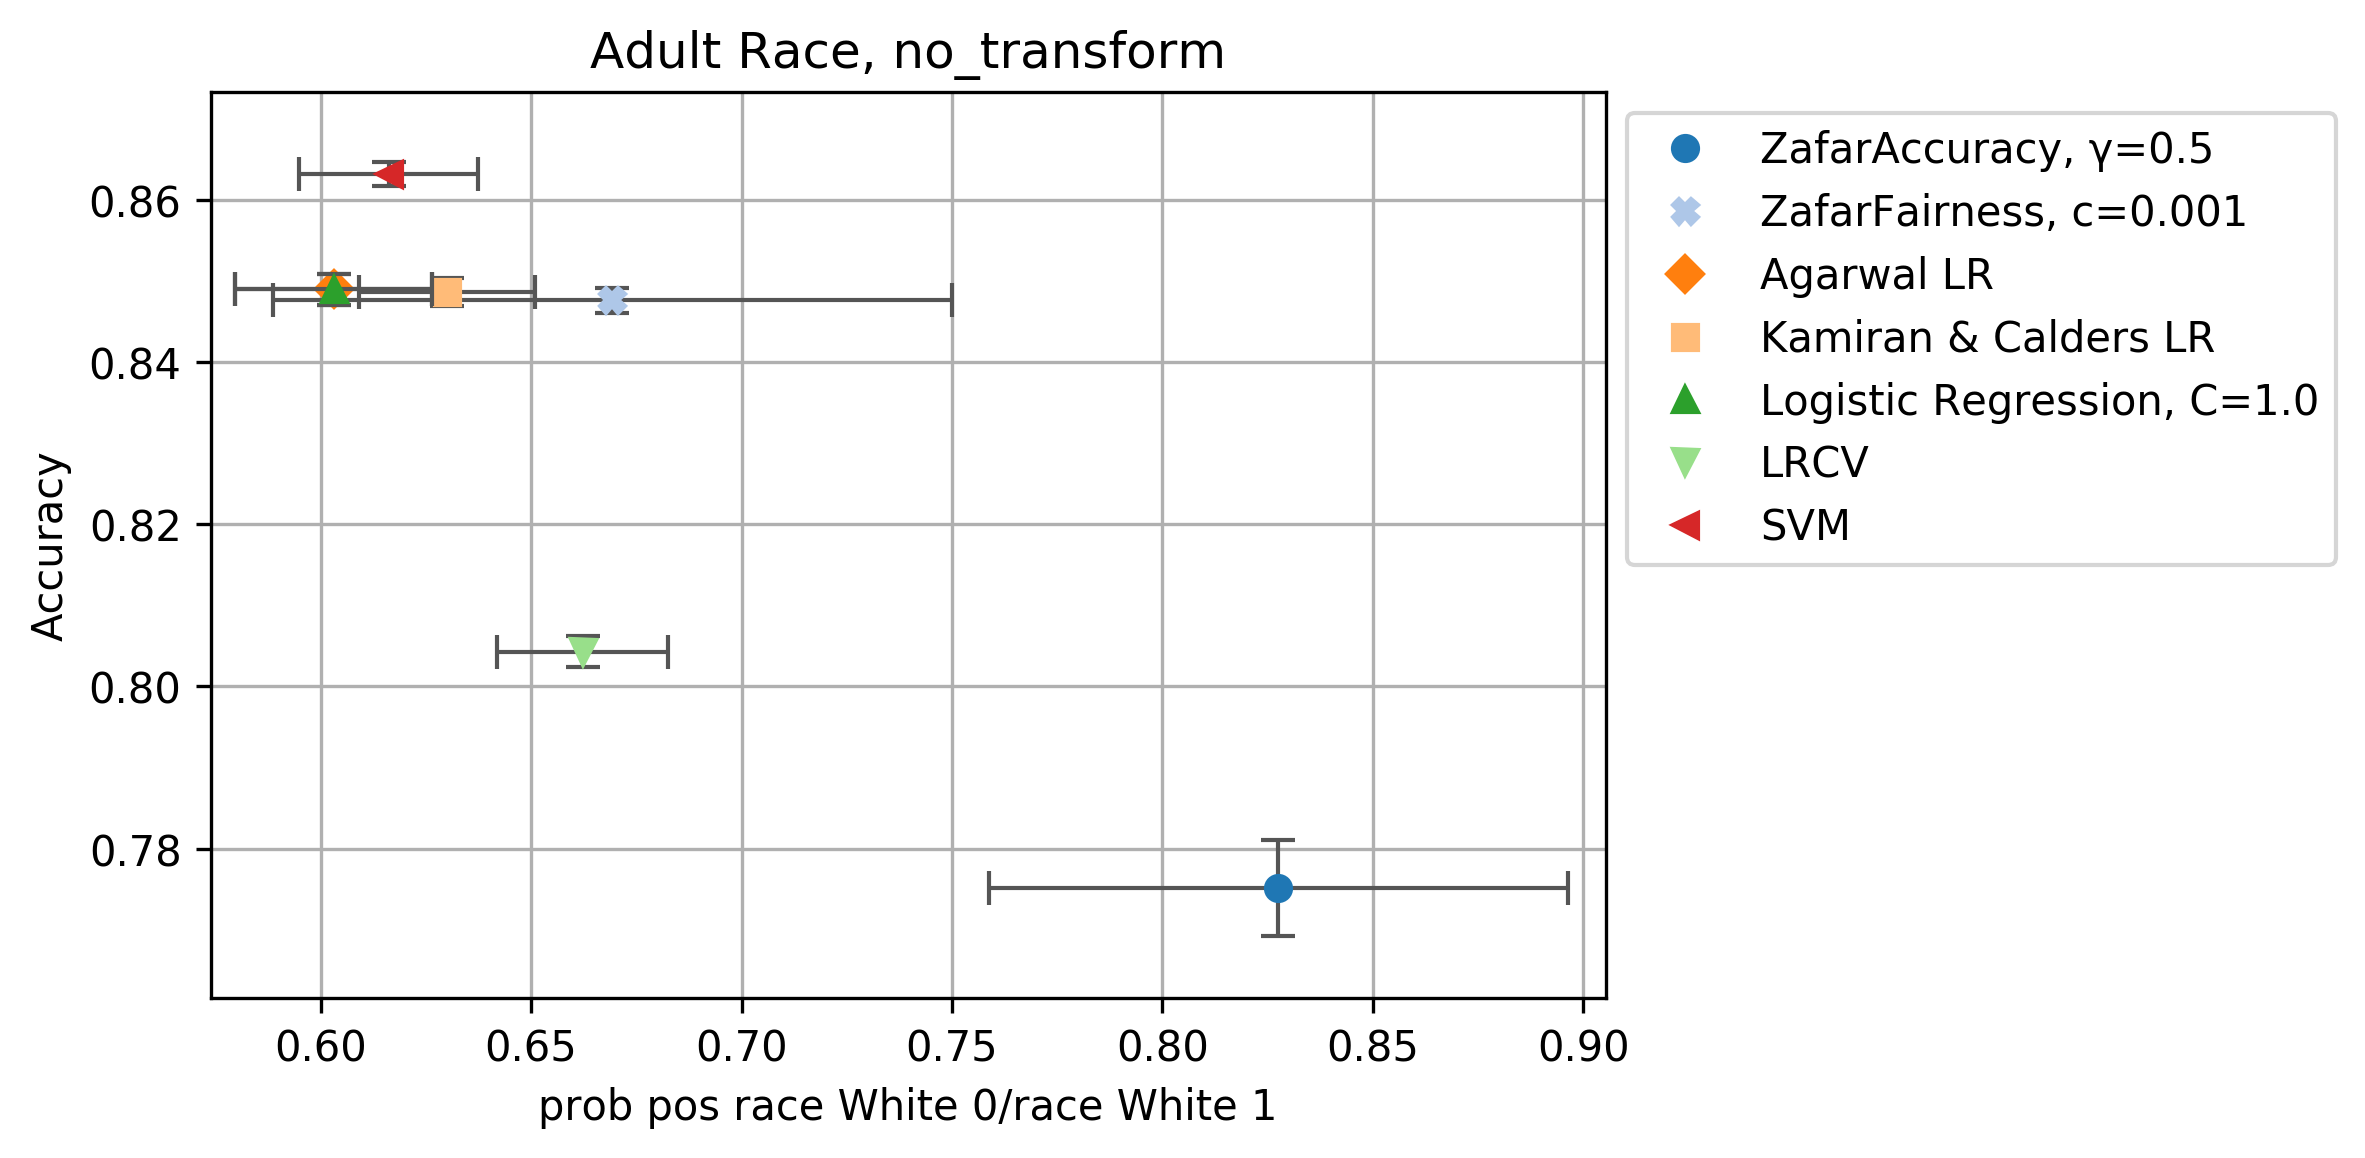

In [7]:
plot_mean_std_box(dp_results, "Accuracy", "prob_pos_race_White_0/race_White_1", save=False, use_cross=True)[0][0]

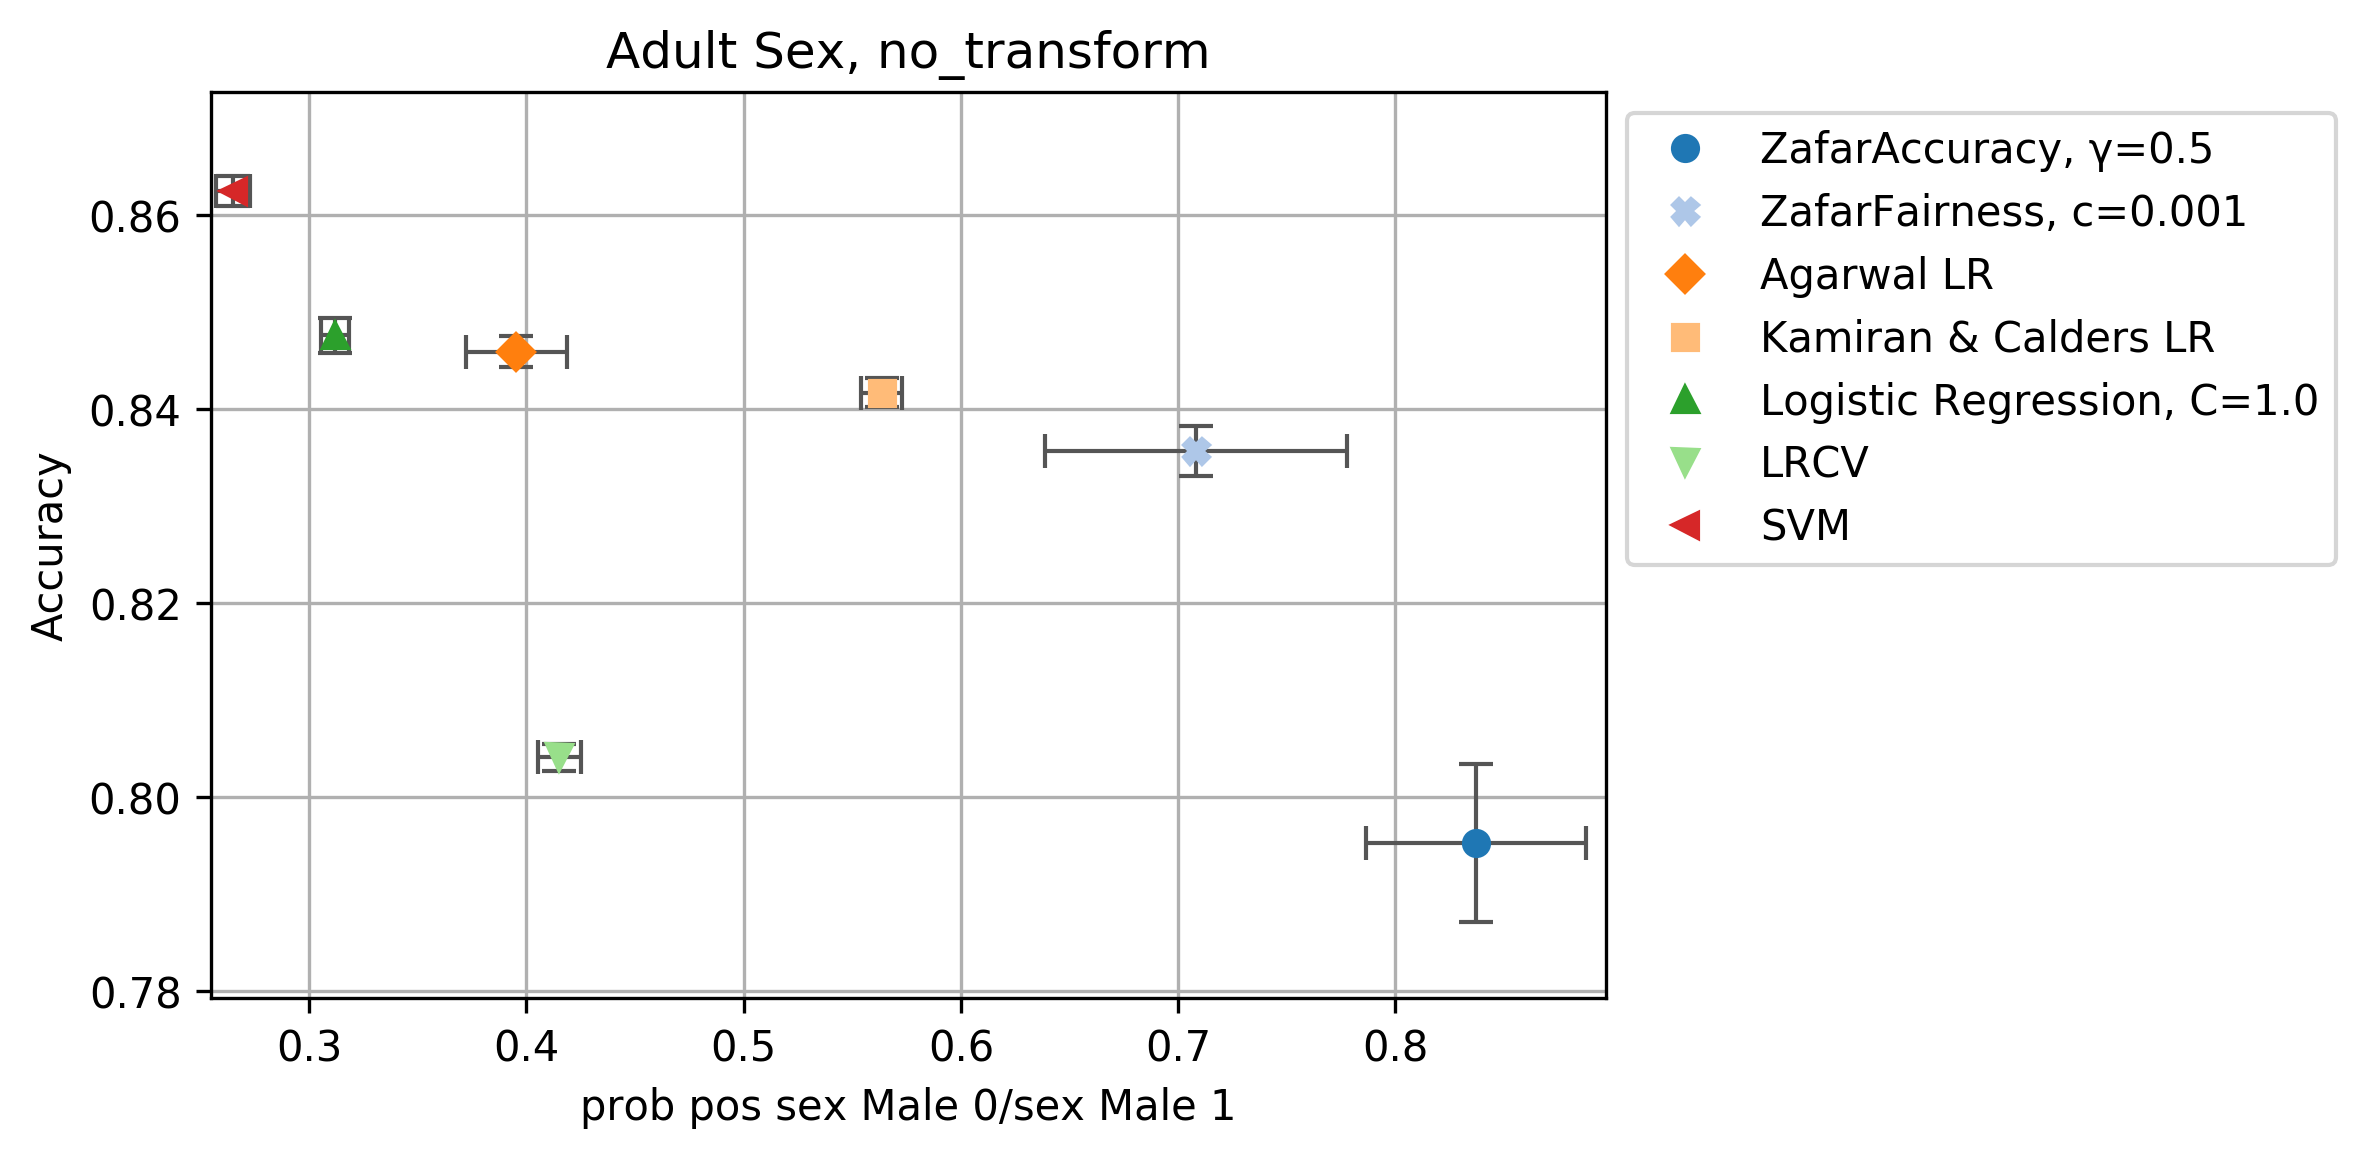

In [6]:
plot_mean_std_box(dp_results, "Accuracy", "prob_pos_sex_Male_0/sex_Male_1", save=False, use_cross=True)[0][0]